<a href="https://colab.research.google.com/github/brs1977/neural-university/blob/master/neural_course_segmentation_07_v_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11 марта состоялся седьмой вебинар курса «Сегментация и продвинутые операции со свёрткой»


Те, кто не смог к нам присоединиться, могут посмотреть вебинар в записи 

Смотреть запись вебинара
https://youtu.be/4vlSG-MKZDc

Скачать материалы к занятию
https://drive.google.com/file/d/1rekIJAI99ftOzZumINWFjkNrk51OMQLN/view

Скачать презентацию вебинара
https://drive.google.com/open?id=1UKrc6jEA1GNsYQhY5Al1eAyHTHpCytDR

Раскадровку вебинара мы подготовили для вас в описании к видео на Youtube!

Домашнее задание:

Задание Light:
 
Есть фреймворк моделей сегментации https://github.com/qubvel/segmentation_models обучить сеть Unet или на данных https://www.cityscapes-dataset.com/ или https://drive.google.com/file/d/0B0d9ZiqAgFkiOHR1NTJhWVJMNEU/view
 
Код для многоклассовой сегментации 
model = Unet('resnet34', input_shape=(352,480, 3), intencoder_weights='imagenet', classes=6, activation='softmax') 
model.compile('Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'] 

Задание Pro:
 
Есть код структуры модели Unet. Обучить сеть Unet или на данных https://www.cityscapes-dataset.com/ или https://drive.google.com/file/d/0B0d9ZiqAgFkiOHR1NTJhWVJMNEU/view
Поизменять модель и посмотреть на скорость обучения и качество сегментации 

Формат меток в файлах: цвет для cityscape, индекс в RGB для google drive: R=2 G=2 B=2 для класса 2, R=3 G=3 B=3 для класса 3. Всего 12 классов. Можно взять первые 6 классов, остальные расценивать как другой или первый. 
Формат меток для нейронки: [batch size, height, width, numClasses] 
по последней размерности - one-hot вектор с индексом класса [0, 1, 0, 0, 0, 0] 

1. пути ко всем файлам: 
glob.glob(path + "*.png") 
2. перемешивание массива: 
arr = np.arange(lenght) 
np.random.shuffle(arr) 
images = np.asarray(images)[arr] 
3. Генератор: 
while True: 
... 
yield np.array(imagesBatch), np.array(labelsBatch) 

3. Бесконечно брать из последовательности с помощью next: 
t = itertools.cycle(zip(images, labels)) 
im, lab = next(t) 
4. Препроцессинг: 
img = img.astype(np.float32) 
5. Ресайзинг, кроппинг, дополнение нулями 
6. Обучение по нескольким эпохам с генератором: 
model.fit_generator(generator(), 512, epochs=10) 
model.save_weights(...) 
7. Для визуализации - перевод индексов в цвета(edited)

##Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -q /content/drive/'My Drive'/dataset1.zip

#Generator

In [0]:
!mkdir dataset1/images_prepped_val
!mkdir dataset1/annotations_prepped_val

test_img_dir = 'dataset1/images_prepped_test'
test_mask_dir = 'dataset1/annotations_prepped_test'

val_img_dir = 'dataset1/images_prepped_test'
val_mask_dir = 'dataset1/annotations_prepped_test'





In [0]:
import os
import numpy as np
np.random.seed(42)

list_images = os.listdir(test_img_dir)
ids = np.arange(len(list_images))
np.random.shuffle(ids)

for i in ids[:-10]:
  os.rename(test_img_dir+'/'+list_images[i],'dataset1/images_prepped_val/'+list_images[i])
  os.rename(test_mask_dir+'/'+list_images[i],'dataset1/annotations_prepped_val/'+list_images[i])


In [0]:
import os
import numpy as np
import cv2

seed = 13
num_class = 7
batch_size = 3
target_size = (352,480)
img_dir = 'dataset1/images_prepped_train'
mask_dir = 'dataset1/annotations_prepped_train'

n_samples = len(os.listdir(img_dir))
n_val_samples = len(os.listdir(val_img_dir))
n_test_samples = len(os.listdir(test_img_dir))


  
def gen(img_dir, mask_dir, num_class, batch_size, target_size):
    np.random.seed(seed)
    
    list_images = os.listdir(img_dir)
    ids_train = np.arange(len(list_images))
    np.random.shuffle(ids_train)
    
    while True:
         for start in range(0, len(list_images), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(list_images))
            ids_train_batch = ids_train[start:end]
            
            for id in ids_train_batch:
                img = cv2.imread(os.path.join(img_dir, list_images[id]))
                img = cv2.resize(img, (target_size[0], target_size[1]))
                mask = cv2.imread(os.path.join(mask_dir, list_images[id]))
                mask = cv2.resize(mask, (target_size[0], target_size[1]))
                #one hot encoding
                mask[mask>5] = 6
                mask = mask[:,:,0]
                new_mask = np.zeros(mask.shape + (num_class,))
                for i in range(num_class):
                    #for one pixel in the image, find the class in mask and convert it into one-hot vector
                    index = np.where(mask == i)
                    index_mask = (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
                    new_mask[index_mask] = 1
                    new_mask[mask == i,i] = 1    
                mask = new_mask
                
                #print(img.shape)
                #print(mask.shape)
                
                x_batch.append(img)
                y_batch.append(mask)

            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32)      
            #print(x_batch.shape)
            #print(y_batch.shape)
            yield x_batch, y_batch
            
def train_generator():  
    yield from gen(img_dir=img_dir, mask_dir=mask_dir, num_class=num_class, batch_size=batch_size, target_size=target_size)
  
def val_generator():  
    yield from gen(img_dir=val_img_dir, mask_dir=val_mask_dir, num_class=num_class, batch_size=batch_size, target_size=target_size)
  
def test_generator():  
    yield from gen(img_dir=test_img_dir, mask_dir=test_mask_dir, num_class=num_class, batch_size=batch_size, target_size=target_size)
            

#Функция отображения рез-тов

In [0]:
#from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt


colors = np.array([
  [50, 56, 200], [220, 188, 50],
	[86, 31, 4], [103, 86, 65],
	[125, 46, 190], [62, 174, 50],
  [256, 0, 0]
])

def show_predict(model):
  list_images = os.listdir(test_img_dir)

  fig, axeslist = plt.subplots(ncols=3, nrows=len(list_images), figsize=(target_size[0]/9,target_size[1]/9))

  for idx, img_name in enumerate(list_images):  
    img_path = test_img_dir + '/' + img_name
    img = cv2.imread(img_path)
    img = cv2.resize(img, (target_size[0], target_size[1]))
    x_batch = []
    x_batch.append(img)
    x_batch = np.array(x_batch, np.float32) / 255.
    #print(x_batch)
    pred = model.predict(x_batch, batch_size=1)

    img_pred = np.argmax(pred.squeeze(),axis=2)
    blank_image = np.zeros((img_pred.shape[0],img_pred.shape[1],3), np.uint8)
    blank_image = colors[img_pred]
    img_pred = blank_image


    img_path = 'dataset1/annotations_prepped_test/' + img_name
    img_val = cv2.imread(img_path)
    img_val = cv2.resize(img_val, (target_size[0], target_size[1]))
    img_val[img_val[:,:,0]>5] = 6
    img_val = colors[img_val[:,:,0]]

    axeslist[idx][0].set_title('Origin')
    axeslist[idx][0].imshow(img)
    axeslist[idx][1].set_title('Mask')
    axeslist[idx][1].imshow(img_val)
    axeslist[idx][2].set_title('Predicted mask')
    axeslist[idx][2].imshow(img_pred)

  plt.tight_layout()  
  plt.show()  
            


In [0]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials, space_eval
import random

#целевая функция минимизации (для поиска гиперпараметров)
def objective(params):
  np.random.seed(42)
  random.seed(13)

  model = unet(params = params)
  history = model.fit_generator(train_generator(), steps_per_epoch = n_samples // batch_size, epochs=params['epochs'])  
  
  loss = np.max(history.history['dice_coef'])
  
  return {'loss': -loss, 'status': STATUS_OK}  

def space_eval_trial(space, trial):
    for_eval = {}
    for k, v in trial["misc"]["vals"].items():
        if len(v) == 0:
            for_eval[k] = None
        else:
            for_eval[k] = v[0]
    return space_eval(space, for_eval)

In [0]:
#параметры оптимизации
space = { 'leakyrelu' : hp.choice('leakyrelu', [True,False]), 
          'epochs': 8, 
          'drop' : .7,#hp.choice('drop', [.3,.4,.5,.6,.7]), 
          'alpha' : .02,
          #'alpha' : hp.choice('alpha', [.02,.03,.04,.05]), 
          #'lr' : hp.choice('lr', [1e-4, 1e-5]),
        }

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, trials=trials, max_evals=2)

print (best)

In [0]:
for trial in sorted(trials, key=lambda x: x['result']['loss'], reverse=False):
  print(-trial['result']['loss'],space_eval_trial(space, trial))

0.8482457471417857 {'alpha': 0.02, 'drop': 0.7, 'epochs': 8, 'leakyrelu': True}
0.8467170754959296 {'alpha': 0.02, 'drop': 0.7, 'epochs': 8, 'leakyrelu': True}


In [0]:
0.8378592682081264 {'alpha': 0.03, 'drop': 0.5, 'epochs': 7, 'leakyrelu': True}
0.8364258862131244 {'alpha': 0.03, 'drop': 0.5, 'epochs': 7, 'leakyrelu': False}
0.8339675083592698 {'alpha': 0.03, 'drop': 0.4, 'epochs': 7, 'leakyrelu': True}
0.833406557748606 {'alpha': 0.03, 'drop': 0.6, 'epochs': 7, 'leakyrelu': True}
0.8327696850666633 {'alpha': 0.03, 'drop': 0.6, 'epochs': 7, 'leakyrelu': False}
0.832449428327791 {'alpha': 0.03, 'drop': 0.4, 'epochs': 7, 'leakyrelu': False}
0.8317280380607961 {'alpha': 0.03, 'drop': 0.4, 'epochs': 7, 'leakyrelu': True}
0.8301212034382663 {'alpha': 0.03, 'drop': 0.4, 'epochs': 7, 'leakyrelu': True}
0.8294800519943237 {'alpha': 0.03, 'drop': 0.5, 'epochs': 7, 'leakyrelu': True}
0.8275206449267628 {'alpha': 0.03, 'drop': 0.6, 'epochs': 7, 'leakyrelu': False}
0.8202488266832226 {'alpha': 0.03, 'drop': 0.4, 'epochs': 7, 'leakyrelu': True}

#Add + kernel_initializer = 'he_normal', 

In [0]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2DTranspose, add, Activation, MaxPooling2D, Conv2D, SeparableConv2D, BatchNormalization, Dropout, LeakyReLU
from keras import backend as K
from keras.optimizers import Adam
SMOOTH = 1e-12

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

def f_score(gt, pr, class_weights=1, beta=1, smooth=SMOOTH, per_image=True):
    r"""The F-score (Dice coefficient) can be interpreted as a weighted average of the precision and recall,
    where an F-score reaches its best value at 1 and worst score at 0.
    The relative contribution of ``precision`` and ``recall`` to the F1-score are equal.
    The formula for the F score is:
    .. math:: F_\beta(precision, recall) = (1 + \beta^2) \frac{precision \cdot recall}
        {\beta^2 \cdot precision + recall}
    The formula in terms of *Type I* and *Type II* errors:
    .. math:: F_\beta(A, B) = \frac{(1 + \beta^2) TP} {(1 + \beta^2) TP + \beta^2 FN + FP}
    where:
        TP - true positive;
        FP - false positive;
        FN - false negative;
    Args:
        gt: ground truth 4D keras tensor (B, H, W, C)
        pr: prediction 4D keras tensor (B, H, W, C)
        class_weights: 1. or list of class weights, len(weights) = C
        beta: f-score coefficient
        smooth: value to avoid division by zero
        per_image: if ``True``, metric is calculated as mean over images in batch (B),
            else over whole batch
    Returns:
        F-score in range [0, 1]
    """
    if per_image:
        axes = [1, 2]
    else:
        axes = [0, 1, 2]

    tp = K.sum(gt * pr, axis=axes)
    fp = K.sum(pr, axis=axes) - tp
    fn = K.sum(gt, axis=axes) - tp

    score = ((1 + beta ** 2) * tp + smooth) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)

    # mean per image
    if per_image:
        score = K.mean(score, axis=0)

    # weighted mean per class
    score = K.mean(score * class_weights)

    return score  
  
def dice_loss(gt, pr, class_weights=1., smooth=SMOOTH, per_image=True):
    r"""Dice loss function for imbalanced datasets:
    .. math:: L(precision, recall) = 1 - (1 + \beta^2) \frac{precision \cdot recall}
        {\beta^2 \cdot precision + recall}
    Args:
        gt: ground truth 4D keras tensor (B, H, W, C)
        pr: prediction 4D keras tensor (B, H, W, C)
        class_weights: 1. or list of class weights, len(weights) = C
        smooth: value to avoid division by zero
        per_image: if ``True``, metric is calculated as mean over images in batch (B),
            else over whole batch
    Returns:
        Dice loss in range [0, 1]
    """
    return 1 - f_score(gt, pr, class_weights=class_weights, smooth=smooth, per_image=per_image, beta=1.)  
  
def generalized_dice_loss_w(y_true, y_pred): 
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    Ncl = y_pred.shape[-1]
    w = np.zeros((Ncl,))
    for l in range(0,Ncl): w[l] = np.sum( np.asarray(y_true[:,:,:,l]==1,np.int8) )
    w = 1/(w**2+0.00001)

    # Compute gen dice coef:
    numerator = y_true*y_pred
    numerator = w*K.sum(numerator,(0,1,2,3))
    numerator = K.sum(numerator)

    denominator = y_true+y_pred
    denominator = w*K.sum(denominator,(0,1,2,3))
    denominator = K.sum(denominator)

    gen_dice_coef = numerator/denominator

    return 1-2*gen_dice_coef
  
def unet(params,num_classes = num_class, input_shape= (480, 352, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', kernel_initializer = 'he_normal', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)
    

    x = Conv2D(64, (3, 3), padding='same', kernel_initializer = 'he_normal', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', kernel_initializer = 'he_normal', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', kernel_initializer = 'he_normal', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      block_2_out = LeakyReLU(alpha=params['alpha'])(x)
    else:
      block_2_out = Activation('relu')(x)

    
    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', kernel_initializer = 'he_normal', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', kernel_initializer = 'he_normal', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', kernel_initializer = 'he_normal', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      block_3_out = LeakyReLU(alpha=params['alpha'])(x)
    else:
      block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', kernel_initializer = 'he_normal', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_initializer = 'he_normal', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_initializer = 'he_normal', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      block_4_out = LeakyReLU(alpha=params['alpha'])(x)
    else:
      block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', kernel_initializer = 'he_normal', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_initializer = 'he_normal', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_initializer = 'he_normal', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    x = Dropout(params['drop'])(x)
    
    # Load pretrained weights.
    for_pretrained_weight = MaxPooling2D()(x)
    vgg16 = Model(img_input, for_pretrained_weight)
    vgg16.load_weights('/content/drive/My Drive/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    x = add([x, block_4_out])
    x = SeparableConv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    x = SeparableConv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    x = add([x, block_3_out])
    x = SeparableConv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    x = SeparableConv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    x = add([x, block_2_out])
    x = SeparableConv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    x = SeparableConv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    x = add([x, block_1_out])
    x = SeparableConv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    x = SeparableConv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    if (params['leakyrelu']):
      x = LeakyReLU(alpha=params['alpha'])(x)
    else:
      x = Activation('relu')(x)

    x = SeparableConv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss=dice_loss,
                  #loss='categorical_crossentropy',                  
                  #loss=generalized_dice_loss_w,
                  metrics=[dice_coef])
                  #metrics=[dice_coef_multilabel])
    #model.summary()
    return model

In [0]:
import random
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler

np.random.seed(42)
random.seed(13)

mode='max'
сheckpoint = ModelCheckpoint('unet3.hdf5', 
                              monitor='val_dice_coef', 
                              save_best_only=True,
                              mode=mode,
                              verbose=1)

earlystop = EarlyStopping(monitor='val_dice_coef', min_delta=0.001, patience=10,verbose=1, mode=mode)

params = {'leakyrelu' : True, 'alpha' : 0.05, 'drop' : .5}

model = unet(params = params)
model.fit_generator(train_generator(),
                    steps_per_epoch = n_samples // batch_size,
                    validation_data=val_generator(),
                    validation_steps=n_samples // batch_size, 
                    epochs=100, 
                    callbacks=[сheckpoint,earlystop])


Epoch 1/100
122/122 [==============================] - 156s 1s/step - loss: 0.5701 - dice_coef: 0.5999 - val_loss: 0.4036 - val_dice_coef: 0.7031

Epoch 00001: val_dice_coef improved from -inf to 0.70312, saving model to unet3.hdf5
Epoch 2/100
122/122 [==============================] - 120s 982ms/step - loss: 0.3932 - dice_coef: 0.7946 - val_loss: 0.3675 - val_dice_coef: 0.7501

Epoch 00002: val_dice_coef improved from 0.70312 to 0.75010, saving model to unet3.hdf5
Epoch 3/100
122/122 [==============================] - 119s 977ms/step - loss: 0.3618 - dice_coef: 0.8209 - val_loss: 0.3035 - val_dice_coef: 0.8196

Epoch 00003: val_dice_coef improved from 0.75010 to 0.81957, saving model to unet3.hdf5
Epoch 4/100
122/122 [==============================] - 119s 975ms/step - loss: 0.3487 - dice_coef: 0.8266 - val_loss: 0.4249 - val_dice_coef: 0.6913

Epoch 00004: val_dice_coef did not improve from 0.81957
Epoch 5/100
122/122 [==============================] - 119s 977ms/step - loss: 0.3232 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

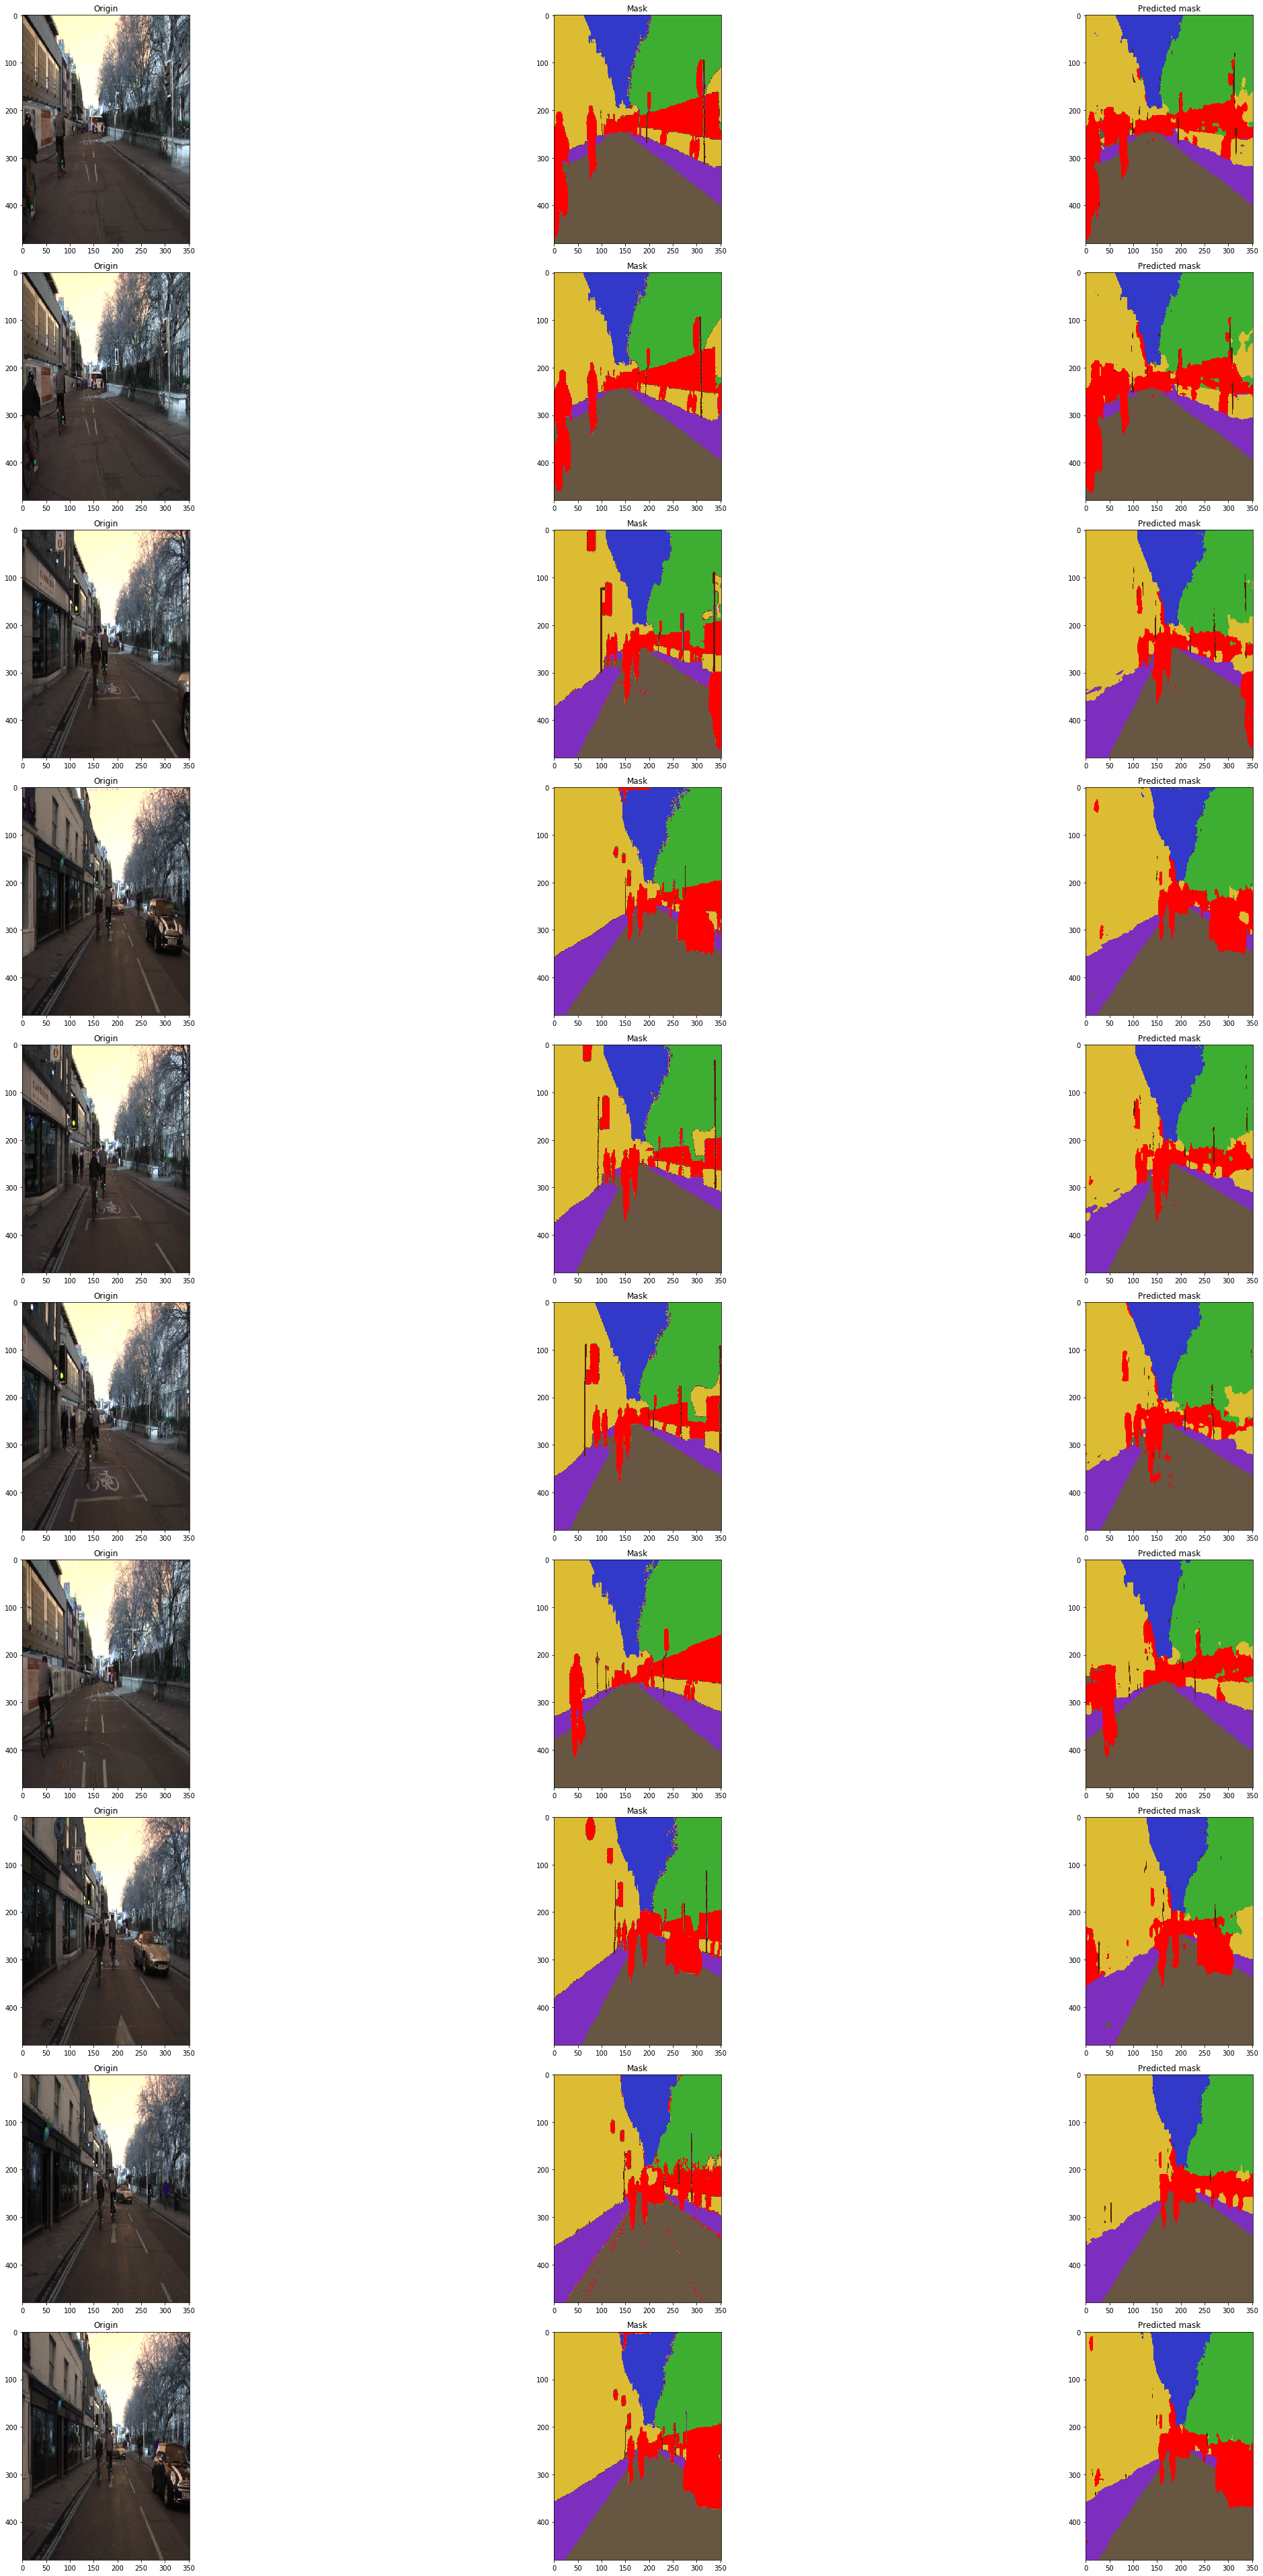

In [0]:
model = unet(params = params)
model.load_weights('unet3.hdf5')

show_predict(model)

#Test encoding image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


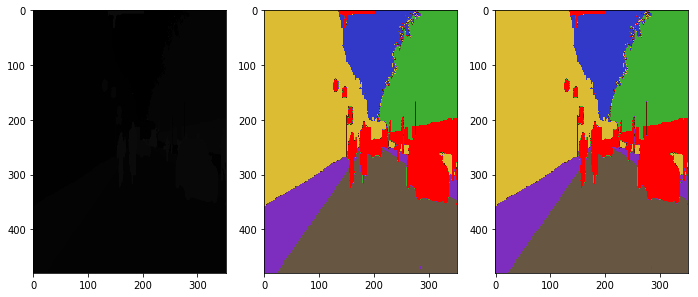

In [0]:
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt

colors = np.array([
  [50, 56, 200], [220, 188, 50],
	[86, 31, 4], [103, 86, 65],
	[125, 46, 190], [62, 174, 50],
  [256, 0, 0]
])

num_class = 7

img_name = 'dataset1/annotations_prepped_test/0016E5_07963.png'
img = cv2.imread(img_name)
img = cv2.resize(img, (target_size[0], target_size[1]))

fig, axeslist = plt.subplots(ncols=3, nrows=1, figsize=(target_size[0]/30,target_size[1]/30))
axeslist[0].imshow(img)

img2 = img.copy()

img2[img2[:,:,0]>5] = 6
img2 = colors[img2[:,:,0]]
axeslist[1].imshow(img2)

mask = img.copy()
#one hot encoding
mask[mask>5] = 6
mask = mask[:,:,0]
new_mask = np.zeros(mask.shape + (num_class,))
for i in range(num_class):
    #for one pixel in the image, find the class in mask and convert it into one-hot vector
    index = np.where(mask == i)
    
    index_mask = (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
    new_mask[index_mask] = 1
    new_mask[mask == i,i] = 1    
mask = new_mask

col_idx = np.argmax(mask,axis=2)
img3 = np.zeros((mask.shape[0],mask.shape[1],3), np.uint8)
img3 = colors[col_idx]
axeslist[2].imshow(img3)

plt.show()



#Вывод.



В основной модель заменил Relu на LeakyReLU, слой concatenate на add, в Conv2D добавил kernel_initializer = 'he_normal', после предобученной модели подменял слои SeparableConv2D, добавил DropOut слой. Добавил dice_loss. В основном это влияет на скорость обучения,  прирост в качестве обучения составил 3-4%.
